In [3]:
!ls

datalab


In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
# !python drive/gan/milestone.grant/code/augmentator.py --gan_type GAN --gen_num 100 --data_root drive/gan/milestone.grant/data/train_preprocessed2.csv --data_type FRAME --y_label Grant.Status

In [7]:
!pip install tqdm
!pip install -q xgboost==0.4a30
!pip install -q keras
!pip install hdbscan

    100% |████████████████████████████████| 61kB 3.1MB/s 
    100% |████████████████████████████████| 4.7MB 284kB/s 
  Running setup.py bdist_wheel for hdbscan ... - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/e0/cc/b5/c52fb2c5cc6fc4b93b0c09177cd1fc1f380047bd1de9db7b30
Successfully built hdbscan


In [8]:
import psutil; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[13662167040, 12297478144]
[13662167040, 12295319552]


In [9]:
import drive.GAN_171103
import importlib
from drive.GAN_171103 import *

Using TensorFlow backend.


In [10]:
data = pd.read_csv('drive/gan/milestone.grant/data/train_preprocessed2.csv')

data_cols = list(data.columns[ data.columns != 'Grant.Status'])
label_cols = ['Grant.Status']

print(data_cols)
print('# of data columns: ', len(data_cols))

['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries', 'Perc_non_australian', 'Number.people', 'PHD', 'Max.years.univ', 'Grants.succ', 'Grants.unsucc', 'Departments', 'Perc.Lang.Eng', 'Perc.Lang.Other', 'Dif.Role', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age', 'Weekday', 'Month', 'Day.of.Month', 'Day.of.Year', 'Season', 'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band', 'RFCD.0', 'RFCD.1', 'RFCD.2', 'RFCD.3', 'RFCD.4', 'RFCD.5', 'RFCD.6', 'RFCD.7', 'RFCD.8', 'RFCD.9', 'RFCD.10', 'RFCD.11', 'RFCD.12', 'RFCD.13', 'RFCD.14', 'RFCD.15', 'RFCD.16', 'RFCD.17', 'RFCD.18', 'RFCD.19', 'RFCD.20', 'RFCD.21', 'RFCD.22', 'RFCD.23', 'RFCD.24', 'SEO.0', 'SEO.1', 'SEO.2', 'SEO.3', 'SEO.4', 'SEO.5', 'SEO.6', 'SEO.7', 'SEO.8', 'SEO.9', 'SEO.10', 'SEO.11', 'SEO.12', 'SEO.13', 'SEO.14', 'SEO.15', 'SEO.16', 'SEO.17', 'SEO.18', 'SEO.19']
# of data columns:  70


In [0]:
# EDA

In [12]:
failed_duplicates = sum( data.loc[ data['Grant.Status'] == 0].duplicated())
grant_duplicates = sum( data.loc[ data['Grant.Status'] == 1].duplicated())
total_duplicates = failed_duplicates + grant_duplicates

print( 'Normal duplicates', failed_duplicates )
print( 'Grant duplicates', grant_duplicates )
print(' Total duplicates', total_duplicates )
print( 'Fraction duplicates', total_duplicates / len(data) )

Normal duplicates 102
Grant duplicates 148
 Total duplicates 250
Fraction duplicates 0.0287092328892972


In [13]:
data.skew()

A..papers                   8.671169
A.papers                    4.280486
B.papers                    3.571272
C.papers                    4.354414
Dif.countries               1.086600
Perc_non_australian        -0.679625
Number.people               2.525270
PHD                         2.080137
Max.years.univ              2.141547
Grants.succ                 2.958288
Grants.unsucc               3.229820
Departments                 1.354454
Perc.Lang.Eng               2.594711
Perc.Lang.Other             5.943137
Dif.Role                    1.023818
Perc.CHIEF.INVESTIGATOR    -1.083001
Average.Age                 0.167271
Weekday                     0.038022
Month                      -0.569539
Day.of.Month                0.107223
Day.of.Year                -0.589856
Season                     -0.508087
Sponsor.Code                2.615073
Grant.Category.Code         0.879647
Contract.Value.Band        33.854509
RFCD.0                     -0.418637
RFCD.1                     22.570174
R

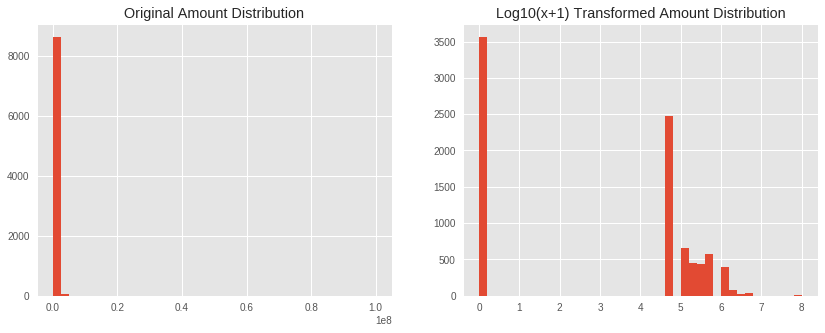

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(data['Contract.Value.Band'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['Contract.Value.Band'].values + 1 )
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

In [0]:
data['Contract.Value.Band'] = d0

In [16]:
percentiles = pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                          columns=data_cols, index=['min', 'max'])
percentile_means = [ [ np.mean( data.loc [ (data[i] >= percentiles[i]['min']) & (data[i] <= percentiles[i]['max']), i ] ) ] for i in data_cols ]
percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )
percentile_stds = [ [ np.std( data.loc[ (data[i] >= percentiles[i]['min']) & (data[i] <= percentiles[i]['max']), i ] ) ] for i in data_cols ]
percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles

,A..papers,A.papers,B.papers,C.papers,Dif.countries,Perc_non_australian,Number.people,PHD,Max.years.univ,Grants.succ,...,SEO.10,SEO.11,SEO.12,SEO.13,SEO.14,SEO.15,SEO.16,SEO.17,SEO.18,SEO.19
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,164.739000,119.000000,69.000000,60.293000,4.000000,1.000000,8.000000,6.293000,85.000000,16.293000,...,3.000000,1.000000,3.000000,5.000000,3.000000,3.000000,2.000000,3.000000,3.000000,1.000000
mean,4.948040,7.064828,5.513908,2.955167,1.045622,0.659637,1.486667,0.908725,11.402138,1.709392,...,0.046394,0.008614,0.030087,0.974736,0.047542,0.186279,0.017814,0.095851,0.148254,0.002067
stdev,9.850045,11.643811,8.181556,5.612036,0.532217,0.444303,0.993048,0.854350,11.220199,2.209494,...,0.258804,0.092410,0.210572,1.090130,0.273697,0.604039,0.155443,0.411598,0.399184,0.045418


In [0]:
data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

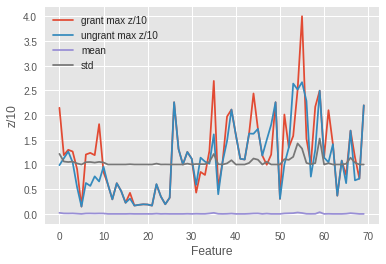

In [18]:
plot_cols = data_cols
plt.plot( data.loc[ data['Grant.Status'] == 1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='grant max z/10' )
plt.plot( data.loc[ data['Grant.Status'] == 0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='ungrant max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean')
plt.plot( data[ plot_cols ].std().values, label='std')
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ;

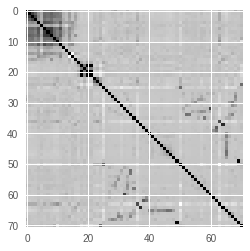

In [19]:
corr0 = data.corr()
plt.imshow(corr0) ;

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


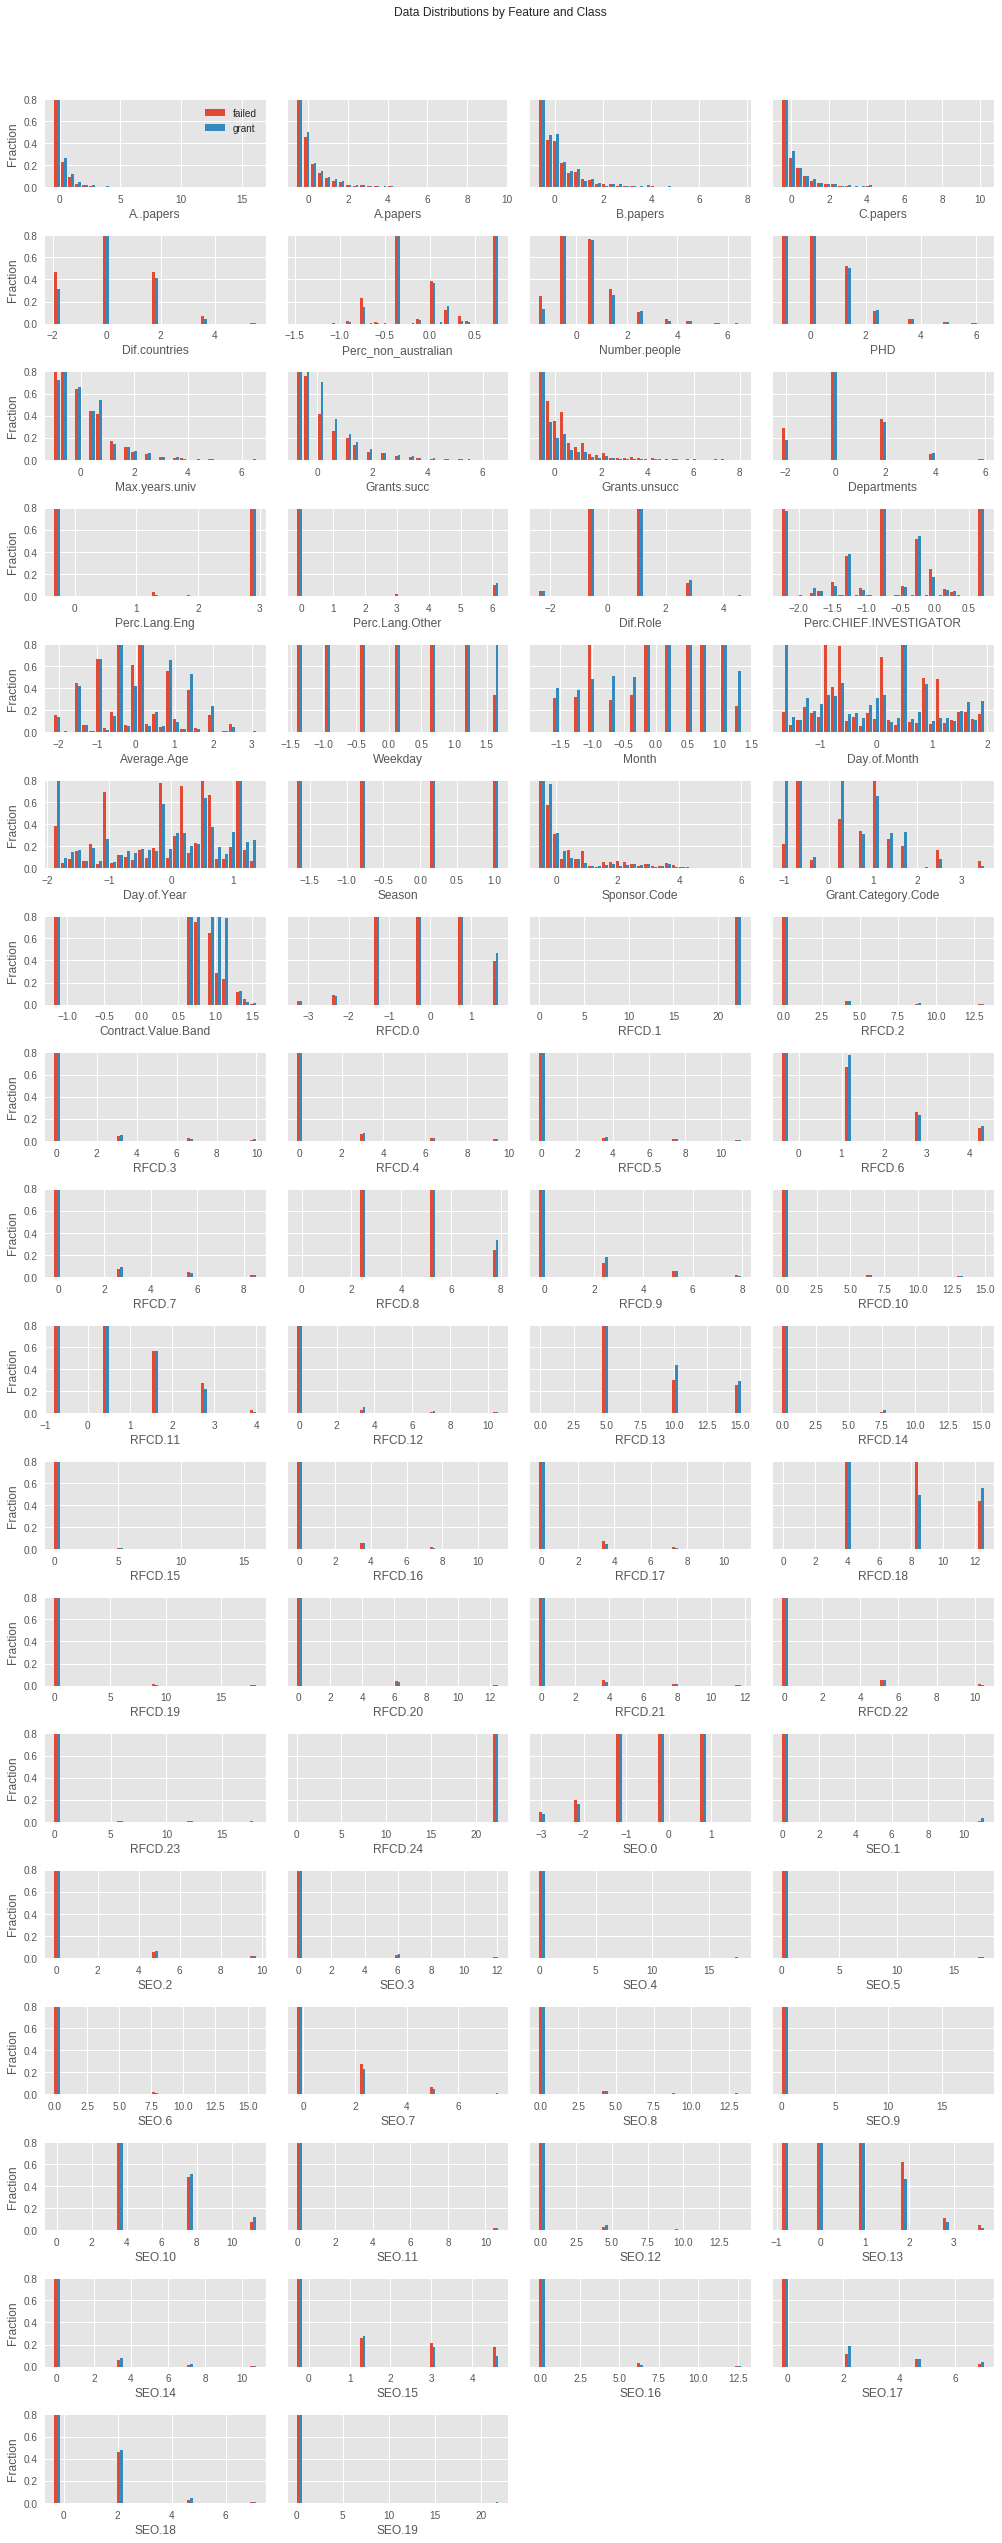

In [20]:
axarr = [[]] * len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns * 3.5, rows * 2) )

f.suptitle('Data Distributions by Feature and Class', size=12)

for i, col in enumerate(data_cols[:]):
  axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
  axarr[i].hist( [ data.loc[ data['Grant.Status'] == 0, col ], data.loc[ data['Grant.Status'] == 1, col ] ], label=['failed', 'grant'], bins=np.linspace( np.percentile(data[col], 0.1), np.percentile(data[col], 99.9), 30 ),
               normed=True )
  axarr[i].set_xlabel(col, size=12)
  axarr[i].set_ylim([0, 0.8])
  axarr[i].tick_params(axis='both', labelsize=10)
  if i == 0:
    legend = axarr[i].legend()
    legend.get_frame().set_facecolor('white')
  if i % 4 != 0:
    axarr[i].tick_params(axis='y', left='off', labelleft='off')
  else:
    axarr[i].set_ylabel('Fraction', size=12)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [21]:
test_cols = data.columns

print(len(test_cols))
print(test_cols)

71
Index(['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries',
       'Perc_non_australian', 'Number.people', 'PHD', 'Max.years.univ',
       'Grants.succ', 'Grants.unsucc', 'Departments', 'Perc.Lang.Eng',
       'Perc.Lang.Other', 'Dif.Role', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age',
       'Weekday', 'Month', 'Day.of.Month', 'Day.of.Year', 'Season',
       'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band', 'RFCD.0',
       'RFCD.1', 'RFCD.2', 'RFCD.3', 'RFCD.4', 'RFCD.5', 'RFCD.6', 'RFCD.7',
       'RFCD.8', 'RFCD.9', 'RFCD.10', 'RFCD.11', 'RFCD.12', 'RFCD.13',
       'RFCD.14', 'RFCD.15', 'RFCD.16', 'RFCD.17', 'RFCD.18', 'RFCD.19',
       'RFCD.20', 'RFCD.21', 'RFCD.22', 'RFCD.23', 'RFCD.24', 'SEO.0', 'SEO.1',
       'SEO.2', 'SEO.3', 'SEO.4', 'SEO.5', 'SEO.6', 'SEO.7', 'SEO.8', 'SEO.9',
       'SEO.10', 'SEO.11', 'SEO.12', 'SEO.13', 'SEO.14', 'SEO.15', 'SEO.16',
       'SEO.17', 'SEO.18', 'SEO.19', 'Grant.Status'],
      dtype='object')


In [0]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
  labels = dtrain.get_label()
  return 'recall', recall_score(labels, np.round(preds))

def precision(preds, dtrain):
  labels = dtrain.get_label()
  return 'precision', precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
  labels = dtrain.get_label()
  return 'roc_auc', roc_auc_score(labels, preds)

In [23]:
np.random.seed(0)

n_real = np.sum(data['Grant.Status'] == 0)
n_test = np.sum(data['Grant.Status'] == 1)
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data['Grant.Status'] == 0, test_cols ].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data['Grant.Status'] == 1, test_cols ].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real], test_samples[:fn_test]], axis=0, ignore_index=True).reset_index(drop=True)
test_df = pd.concat([real_samples[fn_real:], test_samples[fn_test:]], axis=0, ignore_index=True).reset_index(drop=True)

print( 'Classes 0, 1: ', n_real, n_test)
print( 'train, test: ', len(train_df), len(test_df))

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)
print(dtrain.feature_names, dtest.feature_names)

Classes 0, 1:  4716 3992
train, test:  6095 2613
['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries', 'Perc_non_australian', 'Number.people', 'PHD', 'Max.years.univ', 'Grants.succ', 'Grants.unsucc', 'Departments', 'Perc.Lang.Eng', 'Perc.Lang.Other', 'Dif.Role', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age', 'Weekday', 'Month', 'Day.of.Month', 'Day.of.Year', 'Season', 'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band', 'RFCD.0', 'RFCD.1', 'RFCD.2', 'RFCD.3', 'RFCD.4', 'RFCD.5', 'RFCD.6', 'RFCD.7', 'RFCD.8', 'RFCD.9', 'RFCD.10', 'RFCD.11', 'RFCD.12', 'RFCD.13', 'RFCD.14', 'RFCD.15', 'RFCD.16', 'RFCD.17', 'RFCD.18', 'RFCD.19', 'RFCD.20', 'RFCD.21', 'RFCD.22', 'RFCD.23', 'RFCD.24', 'SEO.0', 'SEO.1', 'SEO.2', 'SEO.3', 'SEO.4', 'SEO.5', 'SEO.6', 'SEO.7', 'SEO.8', 'SEO.9', 'SEO.10', 'SEO.11', 'SEO.12', 'SEO.13', 'SEO.14', 'SEO.15', 'SEO.16', 'SEO.17', 'SEO.18', 'SEO.19'] ['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries', 'Perc_non_australian', 'Number.people

In [24]:
results_dict = {}
xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc'
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100,
                    verbose_eval=False,
                    early_stopping_rounds=20,
                    evals=[(dtrain, 'train'), (dtest, 'test')],
                    evals_result = results_dict,
                    feval = recall, maximize=True)

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration + 1)
y_true = test_df['Grant.Status'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall(y_pred, dtest) )
print( precision(y_pred, dtest) )
print( roc_auc(y_pred, dtest) )
SimpleMetrics( np.round(y_pred), y_true)

best iteration:  24
('recall', 0.8956594323873122)
('precision', 0.8667205169628432)
('roc_auc', 0.9586457405451961)
Confusion Matrix


,Pred 0,Pred 1
True 0,1250,165
True 1,125,1073


Accuracy : 0.8890164561806353


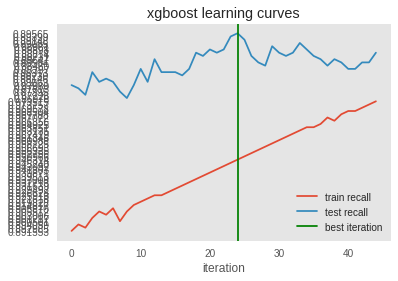

In [25]:
for i in results_dict:
  for err in results_dict[i]:
    plt.plot(results_dict[i][err], label=i + ' ' + err)
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

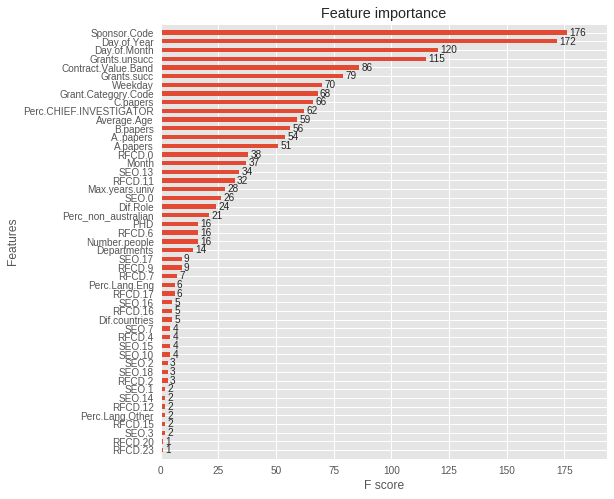

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, height=0.5, ax=ax) ;

In [27]:
import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_cols = [i[0] for i in sorted_x] + ['Grant.Status']
print(sorted_cols)

['Sponsor.Code', 'Day.of.Year', 'Day.of.Month', 'Grants.unsucc', 'Contract.Value.Band', 'Grants.succ', 'Weekday', 'Grant.Category.Code', 'C.papers', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age', 'B.papers', 'A..papers', 'A.papers', 'RFCD.0', 'Month', 'SEO.13', 'RFCD.11', 'Max.years.univ', 'SEO.0', 'Dif.Role', 'Perc_non_australian', 'Number.people', 'RFCD.6', 'PHD', 'Departments', 'RFCD.9', 'SEO.17', 'RFCD.7', 'RFCD.17', 'Perc.Lang.Eng', 'Dif.countries', 'RFCD.16', 'SEO.16', 'SEO.10', 'SEO.15', 'RFCD.4', 'SEO.7', 'RFCD.2', 'SEO.18', 'SEO.2', 'SEO.3', 'RFCD.15', 'Perc.Lang.Other', 'RFCD.12', 'SEO.14', 'SEO.1', 'RFCD.23', 'RFCD.20', 'Grant.Status']


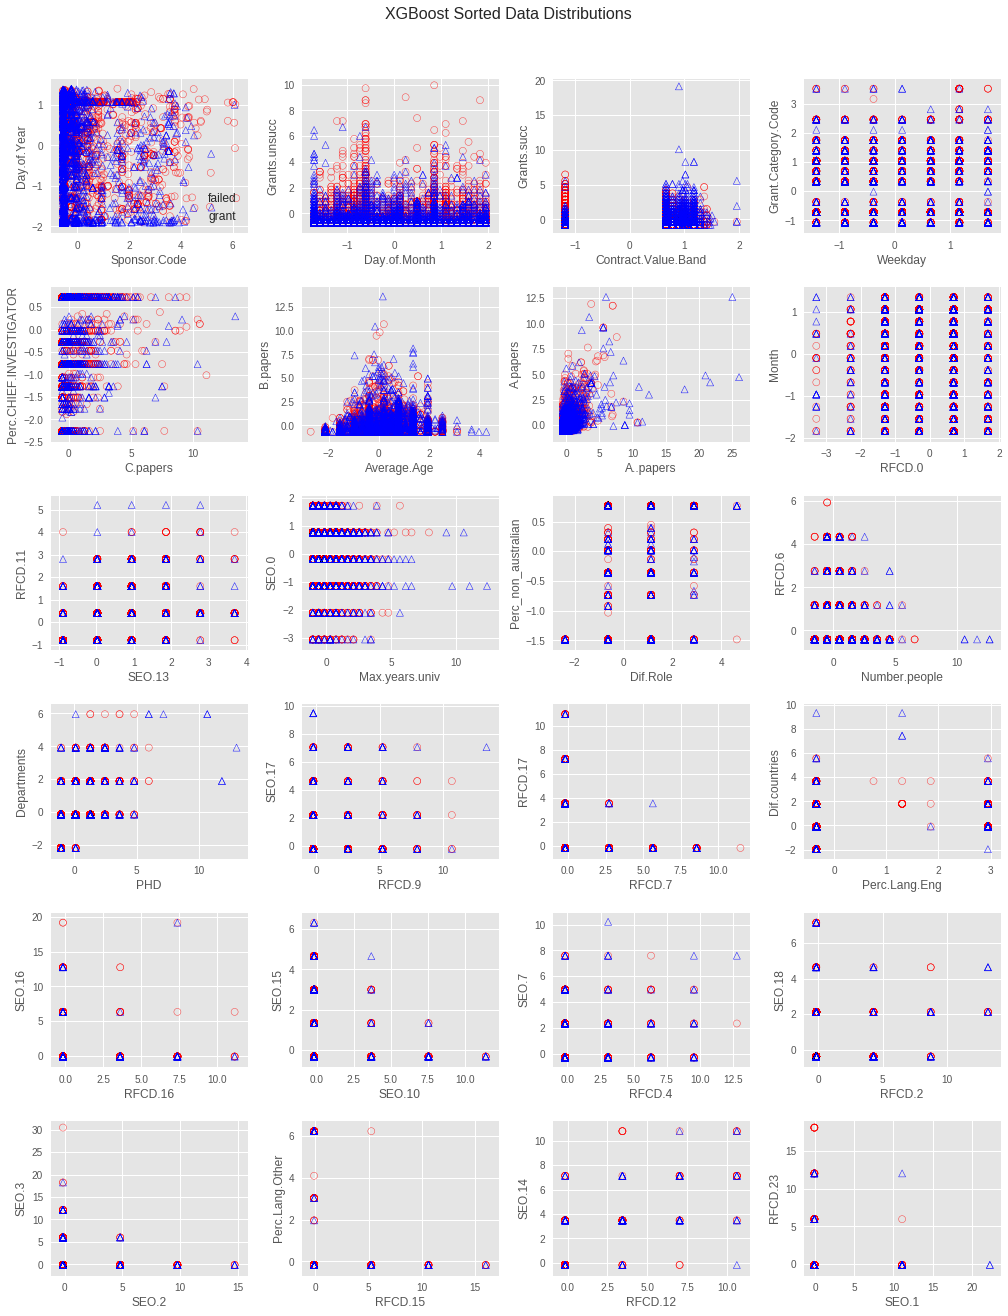

In [28]:
colors = ['red', 'blue']
markers = ['o', '^']
labels = ['failed', 'grant']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns * 3.5, rows * 3) )
plt.suptitle('XGBoost Sorted Data Distributions', size=16)
train = train_df.copy()

for i in range( int(np.floor(len(sorted_x) / 2)) )[:]:
  col1, col2 = sorted_x[i * 2][0], sorted_x[i * 2 + 1][0]
  plt.subplot(rows, columns, i + 1)
  for group, color, marker, label, alpha in zip( train.groupby('Grant.Status'), colors, markers, labels, alphas ):
    plt.scatter( group[1][col1], group[1][col2], label=label, marker=marker, alpha=alpha, edgecolors=color, facecolors='none' )
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    if i == 0:
      plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [29]:
import sklearn.cluster as cluster

import hdbscan

train = data.loc[ data['Grant.Status'] == 1].copy()
print( pd.DataFrame( [ [ np.sum(train['Grant.Status'] == i)] for i in np.unique(train['Grant.Status']) ], columns=['count'], index=np.unique(train['Grant.Status']) ) )

label_cols = [ i for i in train.columns if 'Grant.Status' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

   count
1   3992


0 KMeans
1 Agglomerative
2 HDBSCAN


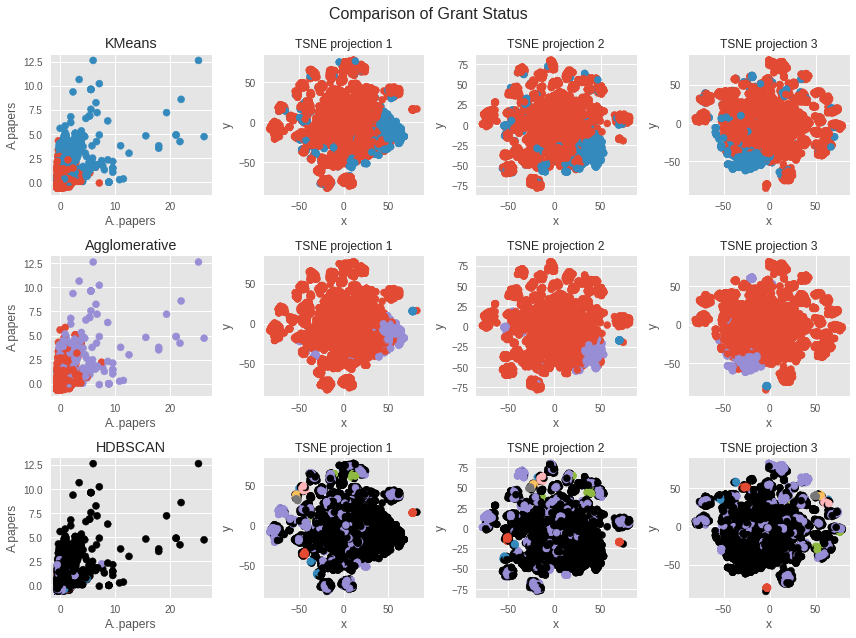

In [30]:
from sklearn.manifold import TSNE
projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]
algorithms = [
    [ 'KMeans', cluster.KMeans, (), {'n_clusters': 2, 'random_state': 0} ],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size': 10, 'min_samples': 1 } ],
]
rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns * 3, rows * 3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
  print(i, name)
  
  labels = algorithm(*args, **kwds).fit_predict(train_no_label)
  colors = np.clip(labels, -1, 9)
  colors = [ 'C' + str(i) if i > -1 else 'black' for i in colors ]
  plt.subplot(rows, columns, i * columns + 1)
  plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
  plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
  plt.title(name)
  
  for j in range(3):
    plt.subplot(rows, columns, i * columns + 1 + j + 1)
    plt.scatter(*(projections[j].T), c=colors)
    plt.xlabel('x'), plt.ylabel('y')
    plt.title('TSNE projection ' + str(j + 1), size=12)
    
plt.suptitle('Comparison of Grant Status', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [31]:
algorithm = cluster.KMeans
args, kwds = (), {'n_clusters': 2, 'random_state': 0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)

print( pd.DataFrame( [ [np.sum(labels == i) ] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

grant_w_classes = train.copy()
grant_w_classes['Grant.Status'] = labels

   count
0   3536
1    456


In [32]:
dtrain = xgb.DMatrix(grant_w_classes[data_cols], grant_w_classes['Grant.Status'], feature_names=data_cols)
print(dtrain.feature_names)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc',
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0], i[1]] for i in sorted_x[:8] ] )

['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries', 'Perc_non_australian', 'Number.people', 'PHD', 'Max.years.univ', 'Grants.succ', 'Grants.unsucc', 'Departments', 'Perc.Lang.Eng', 'Perc.Lang.Other', 'Dif.Role', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age', 'Weekday', 'Month', 'Day.of.Month', 'Day.of.Year', 'Season', 'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band', 'RFCD.0', 'RFCD.1', 'RFCD.2', 'RFCD.3', 'RFCD.4', 'RFCD.5', 'RFCD.6', 'RFCD.7', 'RFCD.8', 'RFCD.9', 'RFCD.10', 'RFCD.11', 'RFCD.12', 'RFCD.13', 'RFCD.14', 'RFCD.15', 'RFCD.16', 'RFCD.17', 'RFCD.18', 'RFCD.19', 'RFCD.20', 'RFCD.21', 'RFCD.22', 'RFCD.23', 'RFCD.24', 'SEO.0', 'SEO.1', 'SEO.2', 'SEO.3', 'SEO.4', 'SEO.5', 'SEO.6', 'SEO.7', 'SEO.8', 'SEO.9', 'SEO.10', 'SEO.11', 'SEO.12', 'SEO.13', 'SEO.14', 'SEO.15', 'SEO.16', 'SEO.17', 'SEO.18', 'SEO.19']
Top eight features:  [['A..papers', 44], ['Grants.succ', 44], ['A.papers', 40], ['B.papers', 34], ['Max.years.univ', 33], ['C.papers', 22], ['Number.peop

In [0]:
import drive.GAN_171103
import importlib
importlib.reload(drive.GAN_171103)
from drive.GAN_171103 import *

rand_dim = 32
base_n_count = 128

nb_steps = 10000
batch_size = 128

k_d = 1
k_g = 1
critic_pre_train_steps = 100
log_interval = 1000
learning_rate = 5e-4
data_dir = 'drive/cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

show = True

train = grant_w_classes.copy().reset_index(drop=True)

label_cols = [ i for i in train.columns if 'Grant.Status' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10
train_no_label = train[ data_cols ]

data_dim:  70
data_cols:  ['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries', 'Perc_non_australian', 'Number.people', 'PHD', 'Max.years.univ', 'Grants.succ', 'Grants.unsucc', 'Departments', 'Perc.Lang.Eng', 'Perc.Lang.Other', 'Dif.Role', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age', 'Weekday', 'Month', 'Day.of.Month', 'Day.of.Year', 'Season', 'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band', 'RFCD.0', 'RFCD.1', 'RFCD.2', 'RFCD.3', 'RFCD.4', 'RFCD.5', 'RFCD.6', 'RFCD.7', 'RFCD.8', 'RFCD.9', 'RFCD.10', 'RFCD.11', 'RFCD.12', 'RFCD.13', 'RFCD.14', 'RFCD.15', 'RFCD.16', 'RFCD.17', 'RFCD.18', 'RFCD.19', 'RFCD.20', 'RFCD.21', 'RFCD.22', 'RFCD.23', 'RFCD.24', 'SEO.0', 'SEO.1', 'SEO.2', 'SEO.3', 'SEO.4', 'SEO.5', 'SEO.6', 'SEO.7', 'SEO.8', 'SEO.9', 'SEO.10', 'SEO.11', 'SEO.12', 'SEO.13', 'SEO.14', 'SEO.15', 'SEO.16', 'SEO.17', 'SEO.18', 'SEO.19']
_________________________________________________________________
Layer (type)                 Output Shape              Param 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 0 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.6759, 0.7536, 0.6790, 0.9878
D Real - D Gen: -0.0746


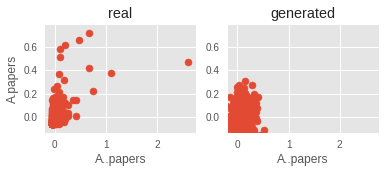

Step: 1000 of 10000.
Losses: G, D Gen, D Real, Xgb: 2.3332, 0.2670, 0.3636, 1.0000
D Real - D Gen: 0.0966


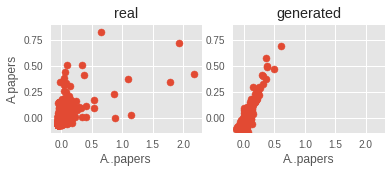

Step: 2000 of 10000.
Losses: G, D Gen, D Real, Xgb: 2.4079, 0.3734, 0.5328, 0.9939
D Real - D Gen: 0.1593


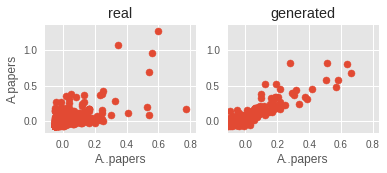

Step: 3000 of 10000.
Losses: G, D Gen, D Real, Xgb: 3.7460, 0.2020, 0.2485, 1.0000
D Real - D Gen: 0.0466


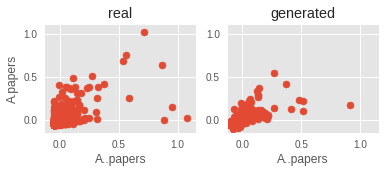

Step: 4000 of 10000.
Losses: G, D Gen, D Real, Xgb: 4.8852, 0.1245, 0.1102, 1.0000
D Real - D Gen: -0.0143


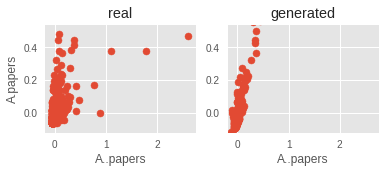

Step: 5000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.1697, 0.1537, 0.1608, 1.0000
D Real - D Gen: 0.0071


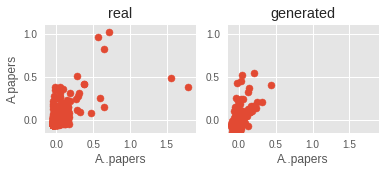

Step: 6000 of 10000.
Losses: G, D Gen, D Real, Xgb: 4.7177, 0.0822, 0.2769, 0.9959
D Real - D Gen: 0.1946


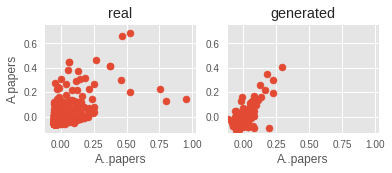

Step: 7000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.7571, 0.1122, 0.1793, 1.0000
D Real - D Gen: 0.0671


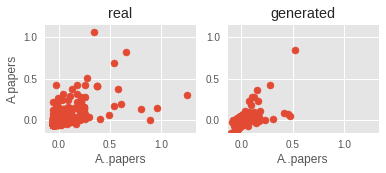

Step: 8000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.9897, 0.0201, 0.0646, 0.9959
D Real - D Gen: 0.0445


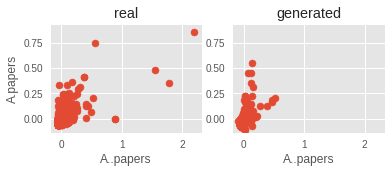

Step: 9000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.0374, 0.1536, 0.2480, 1.0000
D Real - D Gen: 0.0944


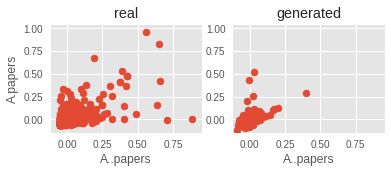

data_dim:  70
data_cols:  ['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries', 'Perc_non_australian', 'Number.people', 'PHD', 'Max.years.univ', 'Grants.succ', 'Grants.unsucc', 'Departments', 'Perc.Lang.Eng', 'Perc.Lang.Other', 'Dif.Role', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age', 'Weekday', 'Month', 'Day.of.Month', 'Day.of.Year', 'Season', 'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band', 'RFCD.0', 'RFCD.1', 'RFCD.2', 'RFCD.3', 'RFCD.4', 'RFCD.5', 'RFCD.6', 'RFCD.7', 'RFCD.8', 'RFCD.9', 'RFCD.10', 'RFCD.11', 'RFCD.12', 'RFCD.13', 'RFCD.14', 'RFCD.15', 'RFCD.16', 'RFCD.17', 'RFCD.18', 'RFCD.19', 'RFCD.20', 'RFCD.21', 'RFCD.22', 'RFCD.23', 'RFCD.24', 'SEO.0', 'SEO.1', 'SEO.2', 'SEO.3', 'SEO.4', 'SEO.5', 'SEO.6', 'SEO.7', 'SEO.8', 'SEO.9', 'SEO.10', 'SEO.11', 'SEO.12', 'SEO.13', 'SEO.14', 'SEO.15', 'SEO.16', 'SEO.17', 'SEO.18', 'SEO.19']
label_dim:  1
label_cols:  ['Grant.Status']
___________________________________________________________________________________

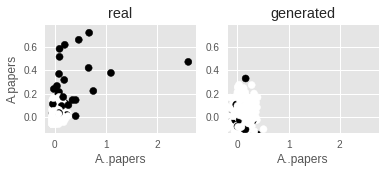

Step: 1000 of 10000.
Losses: G, D Gen, D Real, Xgb: 2.4212, 0.3224, 0.3765, 1.0000
D Real - D Gen: 0.0541


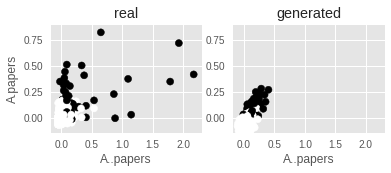

Step: 2000 of 10000.
Losses: G, D Gen, D Real, Xgb: 2.4449, 0.3665, 0.4268, 0.9980
D Real - D Gen: 0.0603


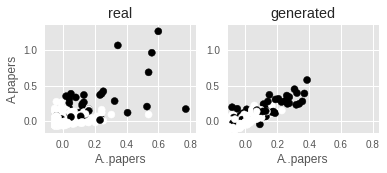

Step: 3000 of 10000.
Losses: G, D Gen, D Real, Xgb: 3.7103, 0.1995, 0.2541, 0.9980
D Real - D Gen: 0.0546


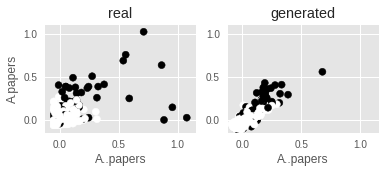

Step: 4000 of 10000.
Losses: G, D Gen, D Real, Xgb: 4.6950, 0.1163, 0.1597, 1.0000
D Real - D Gen: 0.0434


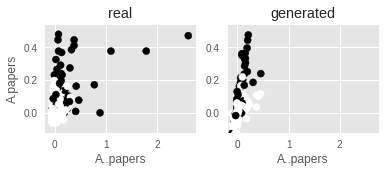

Step: 5000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.6352, 0.1525, 0.1716, 0.9878
D Real - D Gen: 0.0190


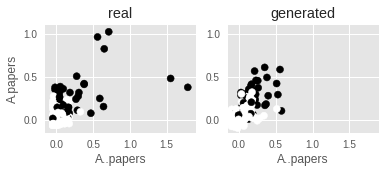

Step: 6000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.3539, 0.2075, 0.3110, 0.9959
D Real - D Gen: 0.1034


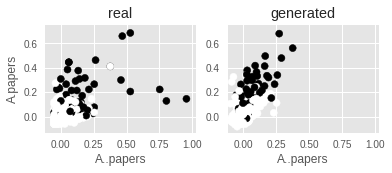

Step: 7000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.2538, 0.0632, 0.1124, 0.9980
D Real - D Gen: 0.0492


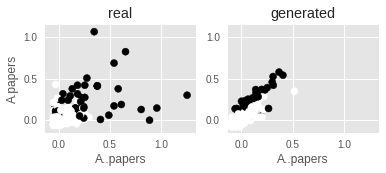

Step: 8000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.7877, 0.0840, 0.0463, 0.9980
D Real - D Gen: -0.0377


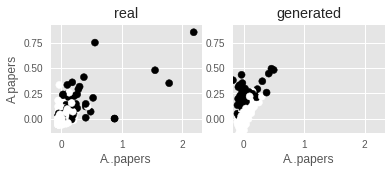

Step: 9000 of 10000.
Losses: G, D Gen, D Real, Xgb: 5.2737, 0.1309, 0.1304, 1.0000
D Real - D Gen: -0.0005


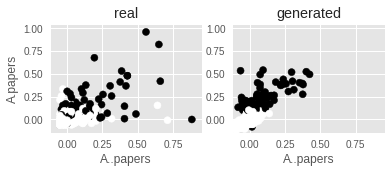

In [34]:
k_d = 1
learning_rate = 5e-4
arguments = [rand_dim, nb_steps, batch_size, k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count, data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]
adversarial_training_GAN(arguments, train_no_label, data_cols)
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols)

data_dim:  70
data_cols:  ['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries', 'Perc_non_australian', 'Number.people', 'PHD', 'Max.years.univ', 'Grants.succ', 'Grants.unsucc', 'Departments', 'Perc.Lang.Eng', 'Perc.Lang.Other', 'Dif.Role', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age', 'Weekday', 'Month', 'Day.of.Month', 'Day.of.Year', 'Season', 'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band', 'RFCD.0', 'RFCD.1', 'RFCD.2', 'RFCD.3', 'RFCD.4', 'RFCD.5', 'RFCD.6', 'RFCD.7', 'RFCD.8', 'RFCD.9', 'RFCD.10', 'RFCD.11', 'RFCD.12', 'RFCD.13', 'RFCD.14', 'RFCD.15', 'RFCD.16', 'RFCD.17', 'RFCD.18', 'RFCD.19', 'RFCD.20', 'RFCD.21', 'RFCD.22', 'RFCD.23', 'RFCD.24', 'SEO.0', 'SEO.1', 'SEO.2', 'SEO.3', 'SEO.4', 'SEO.5', 'SEO.6', 'SEO.7', 'SEO.8', 'SEO.9', 'SEO.10', 'SEO.11', 'SEO.12', 'SEO.13', 'SEO.14', 'SEO.15', 'SEO.16', 'SEO.17', 'SEO.18', 'SEO.19']
_________________________________________________________________
Layer (type)                 Output Shape              Param 

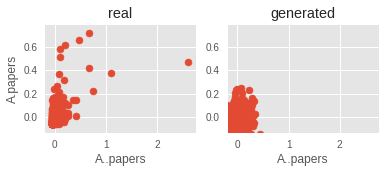

Step: 1000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0183, -0.0218, 0.0177, 1.0000
D Real - D Gen: 0.0395


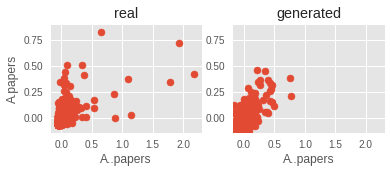

Step: 2000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0213, -0.0245, 0.0187, 0.9858
D Real - D Gen: 0.0433


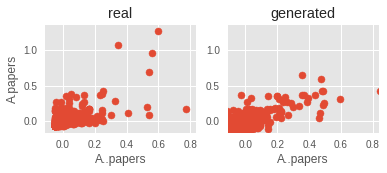

Step: 3000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0262, -0.0294, 0.0058, 1.0000
D Real - D Gen: 0.0352


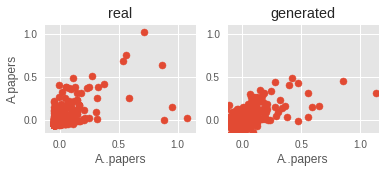

Step: 4000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0270, -0.0324, -0.0049, 1.0000
D Real - D Gen: 0.0274


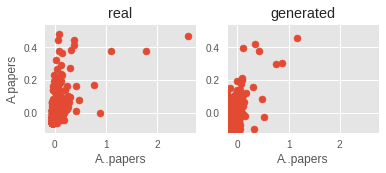

Step: 5000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0315, -0.0349, -0.0120, 1.0000
D Real - D Gen: 0.0229


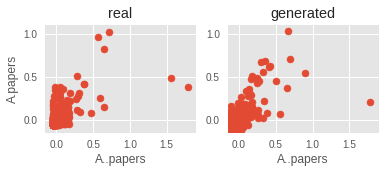

Step: 6000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0349, -0.0422, -0.0112, 1.0000
D Real - D Gen: 0.0310


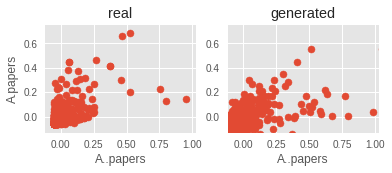

Step: 7000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0447, -0.0508, -0.0282, 0.9980
D Real - D Gen: 0.0226


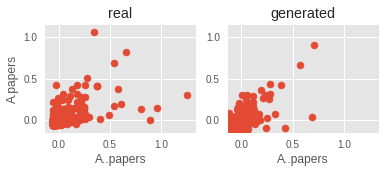

Step: 8000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0496, -0.0558, -0.0278, 0.9980
D Real - D Gen: 0.0280


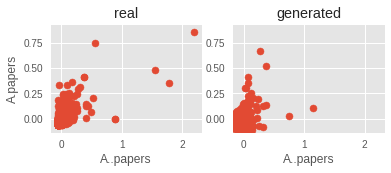

Step: 9000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0515, -0.0583, -0.0366, 1.0000
D Real - D Gen: 0.0217


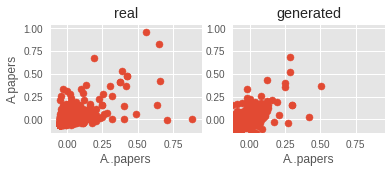

data_dim:  70
data_cols:  ['A..papers', 'A.papers', 'B.papers', 'C.papers', 'Dif.countries', 'Perc_non_australian', 'Number.people', 'PHD', 'Max.years.univ', 'Grants.succ', 'Grants.unsucc', 'Departments', 'Perc.Lang.Eng', 'Perc.Lang.Other', 'Dif.Role', 'Perc.CHIEF.INVESTIGATOR', 'Average.Age', 'Weekday', 'Month', 'Day.of.Month', 'Day.of.Year', 'Season', 'Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band', 'RFCD.0', 'RFCD.1', 'RFCD.2', 'RFCD.3', 'RFCD.4', 'RFCD.5', 'RFCD.6', 'RFCD.7', 'RFCD.8', 'RFCD.9', 'RFCD.10', 'RFCD.11', 'RFCD.12', 'RFCD.13', 'RFCD.14', 'RFCD.15', 'RFCD.16', 'RFCD.17', 'RFCD.18', 'RFCD.19', 'RFCD.20', 'RFCD.21', 'RFCD.22', 'RFCD.23', 'RFCD.24', 'SEO.0', 'SEO.1', 'SEO.2', 'SEO.3', 'SEO.4', 'SEO.5', 'SEO.6', 'SEO.7', 'SEO.8', 'SEO.9', 'SEO.10', 'SEO.11', 'SEO.12', 'SEO.13', 'SEO.14', 'SEO.15', 'SEO.16', 'SEO.17', 'SEO.18', 'SEO.19']
label_dim:  1
label_cols:  ['Grant.Status']
___________________________________________________________________________________

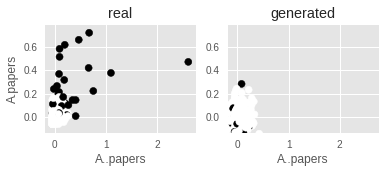

Step: 1000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0218, -0.0241, 0.0160, 1.0000
D Real - D Gen: 0.0402


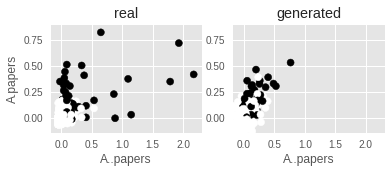

Step: 2000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0336, -0.0377, 0.0068, 1.0000
D Real - D Gen: 0.0446


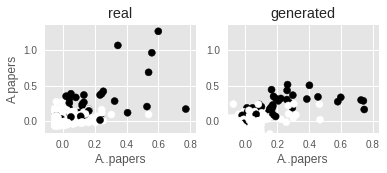

Step: 3000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0349, -0.0347, 0.0015, 1.0000
D Real - D Gen: 0.0363


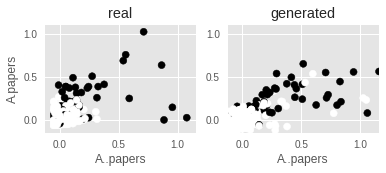

Step: 4000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0414, -0.0458, -0.0181, 1.0000
D Real - D Gen: 0.0277


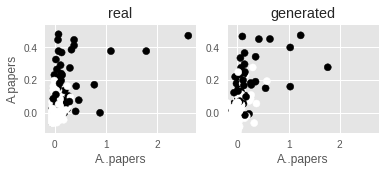

Step: 5000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0413, -0.0424, -0.0183, 0.9980
D Real - D Gen: 0.0241


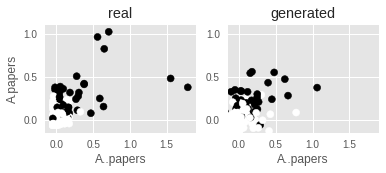

Step: 6000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0491, -0.0536, -0.0229, 0.9980
D Real - D Gen: 0.0307


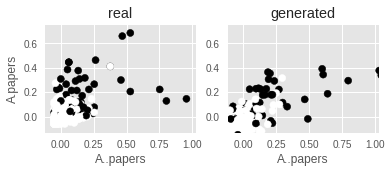

Step: 7000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0647, -0.0670, -0.0475, 1.0000
D Real - D Gen: 0.0196


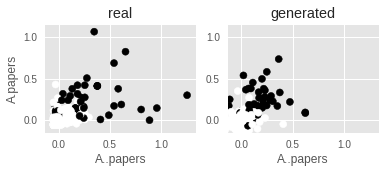

Step: 8000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0663, -0.0709, -0.0475, 1.0000
D Real - D Gen: 0.0234


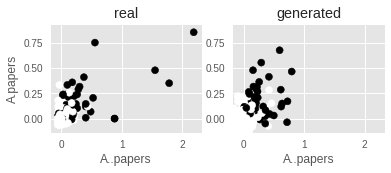

Step: 9000 of 10000.
Losses: G, D Gen, D Real, Xgb: 0.0754, -0.0822, -0.0592, 0.9959
D Real - D Gen: 0.0229


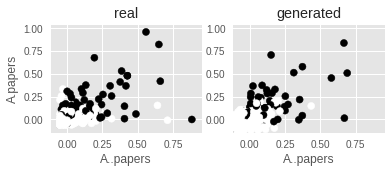

In [35]:
k_d = 5
learning_rate = 1e-4
arguments = [rand_dim, nb_steps, batch_size, k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count, data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols)
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols)

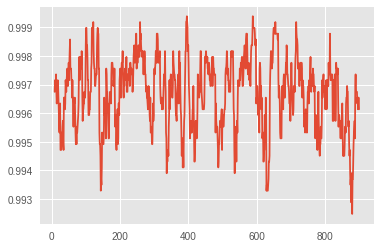

In [36]:
prefix = 'WCGAN'
step = 9000

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl', 'rb'))
w = 10
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean()) ;

In [37]:
best_step = list(xgb_losses).index( xgb_losses.min() ) * 10
print( best_step, xgb_losses.min() )
xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 10) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

6290 0.9715447154471545
15000 0.975609756097561


In [38]:
delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

1 0.0011374076
0 0.0020765495


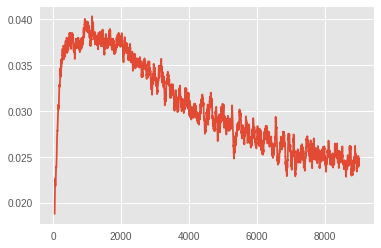

In [39]:
w = 50
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() );

In [0]:
import drive.GAN_171103
import importlib
importlib.reload(drive.GAN_171103)
from drive.GAN_171103 import *

seed = 17

train = grant_w_classes.copy().reset_index(drop=True)

label_cols = [ i for i in train.columns if 'Grant.Status' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0:
  with_class = True
np.random.seed(seed)

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('drive/cache/CGAN_generator_model_weights_step_9000.h5')

test_size = 200

x = get_data_batch(train, test_size, seed=i + j)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
  labels = x[:, -label_dim:]
  g_z = generator_model.predict([z, labels])
else:
  g_z = generator_model.predict(z)

0.995


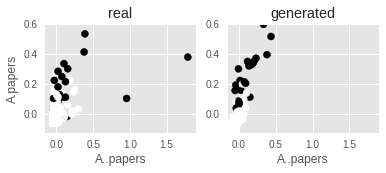

In [41]:
print( CheckAccuracy(x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim) )
PlotData(x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim)

In [42]:
real_samples = pd.DataFrame(x, columns=data_cols + label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols + label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples) * training_fraction), int(len(test_samples) * training_fraction)
train_df = pd.concat([real_samples[:n_real], test_samples[:n_test]], axis=0)
test_df = pd.concat([real_samples[n_real:], test_samples[n_test:]], axis=0)

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc'
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))

print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)))

0.99


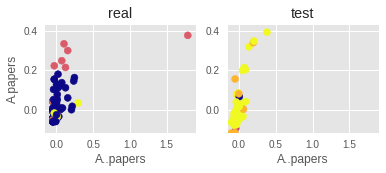

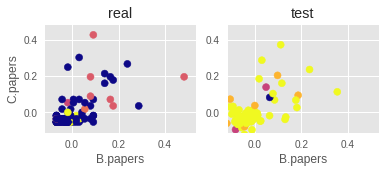

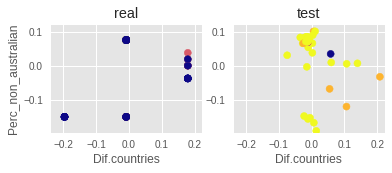

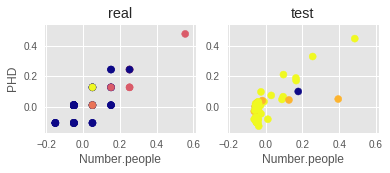

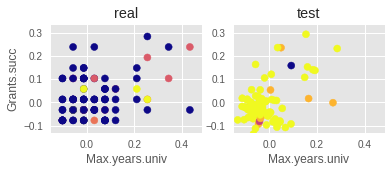

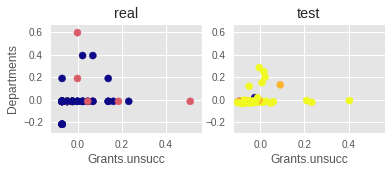

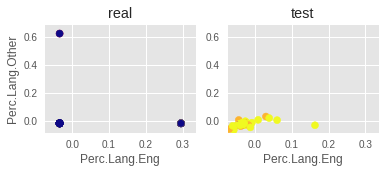

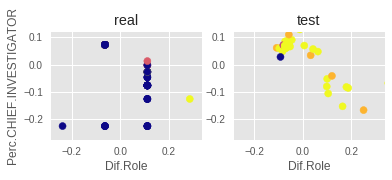

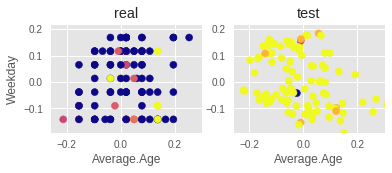

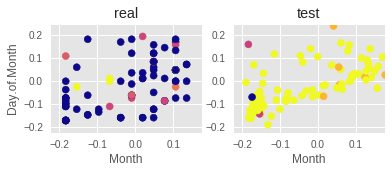

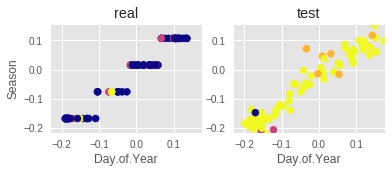

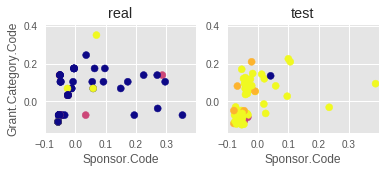

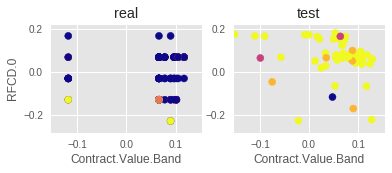

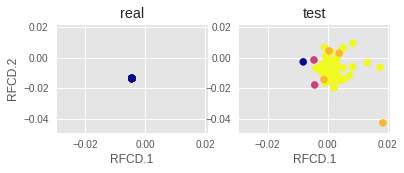

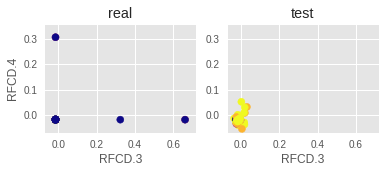

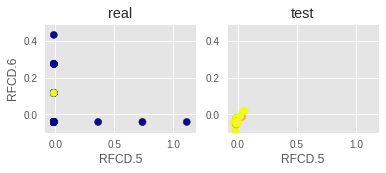

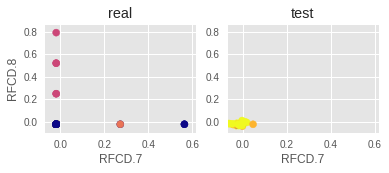

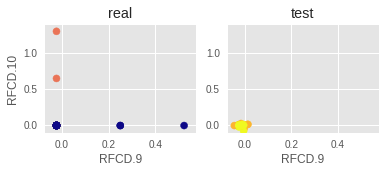

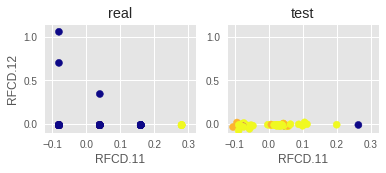

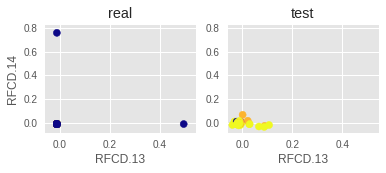

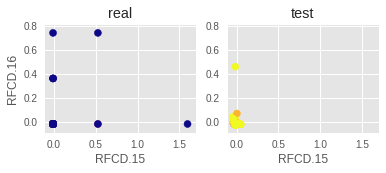

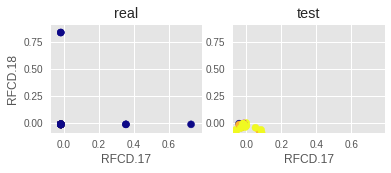

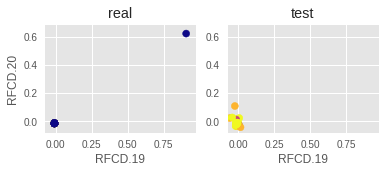

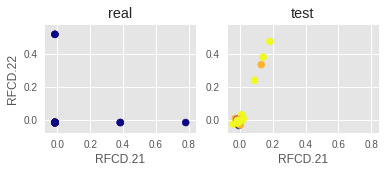

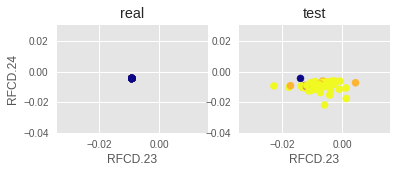

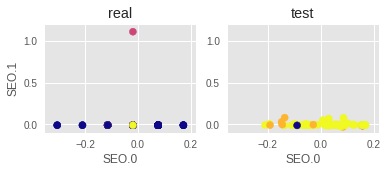

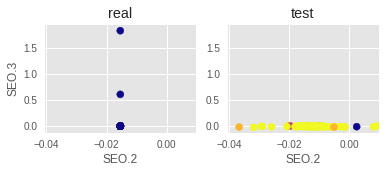

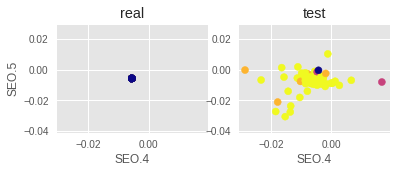

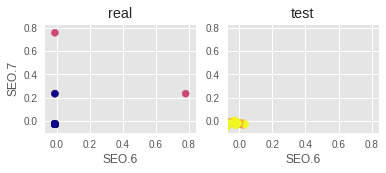

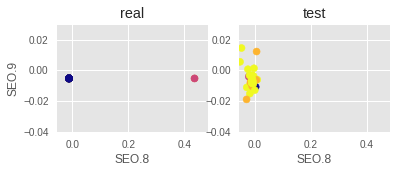

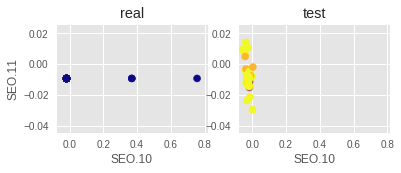

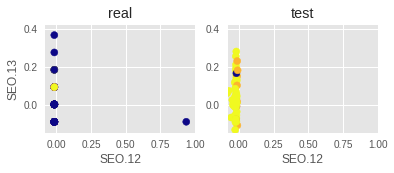

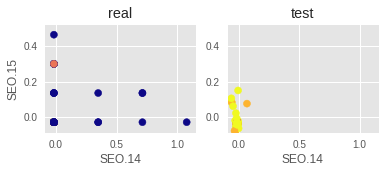

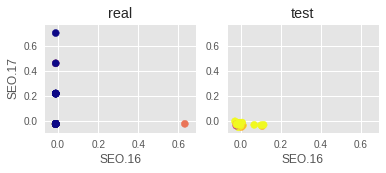

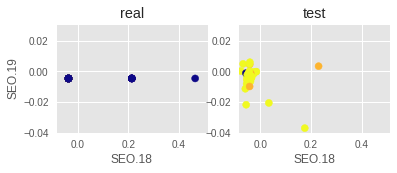

In [43]:
y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()

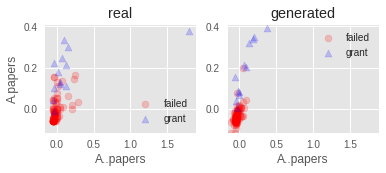

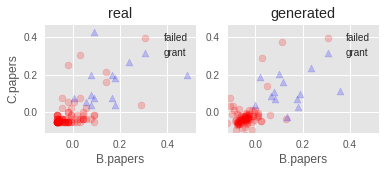

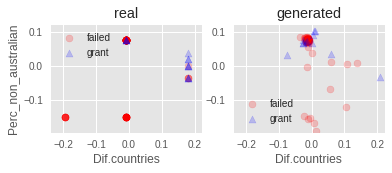

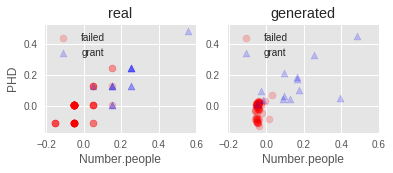

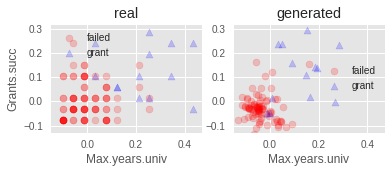

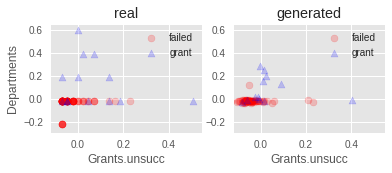

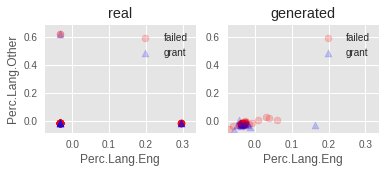

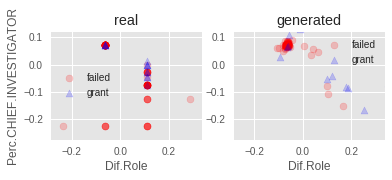

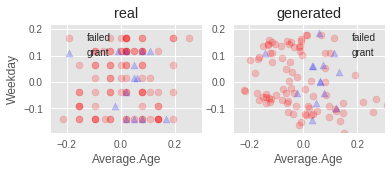

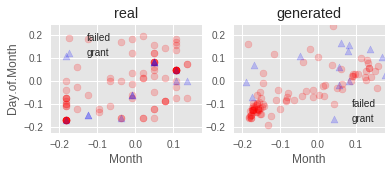

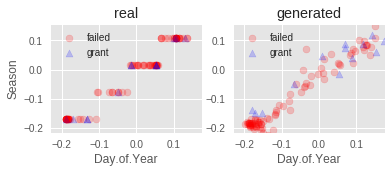

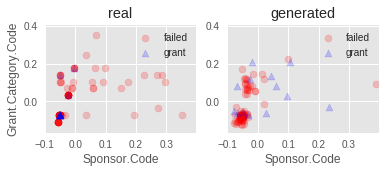

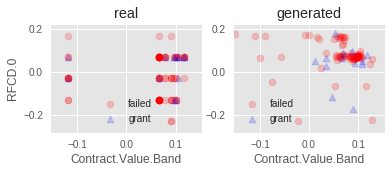

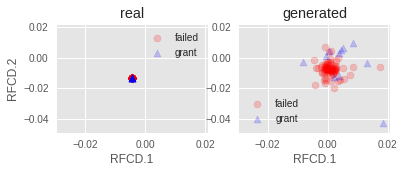

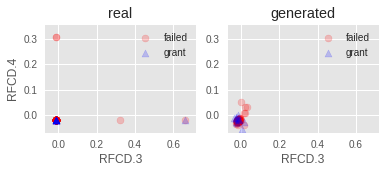

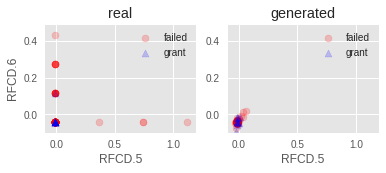

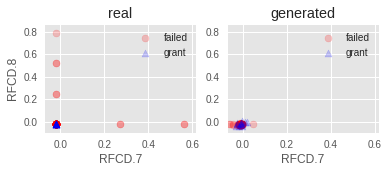

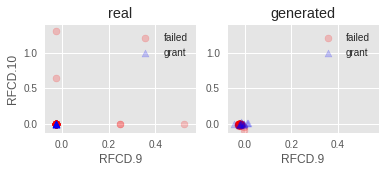

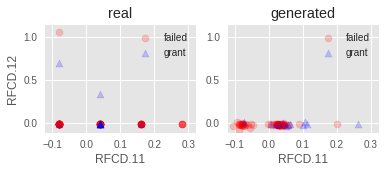

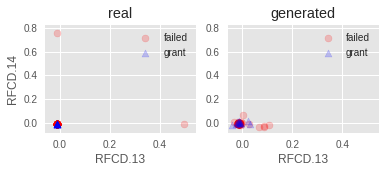

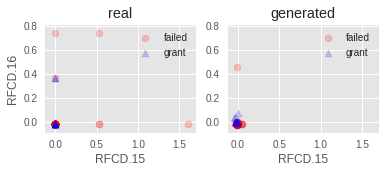

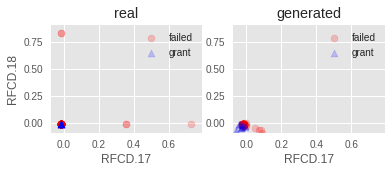

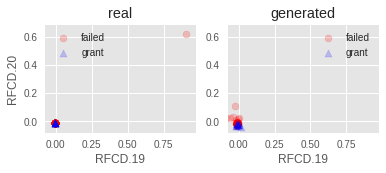

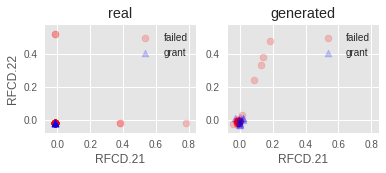

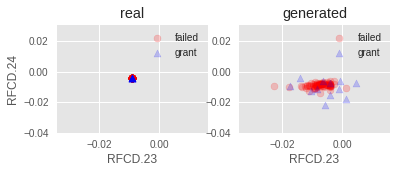

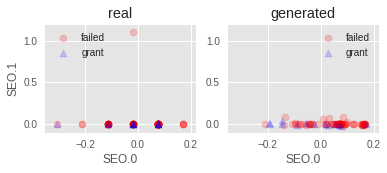

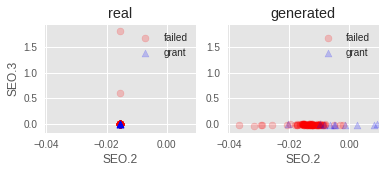

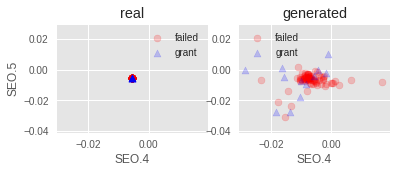

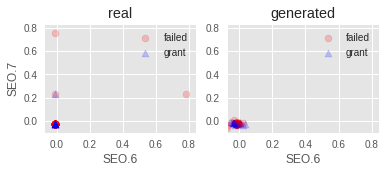

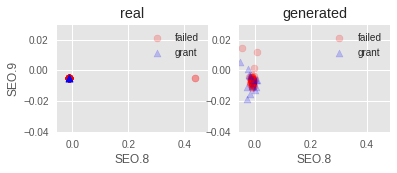

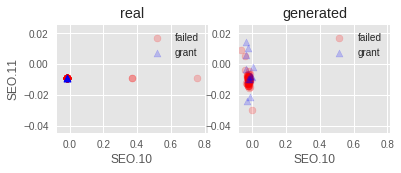

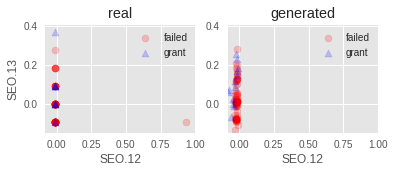

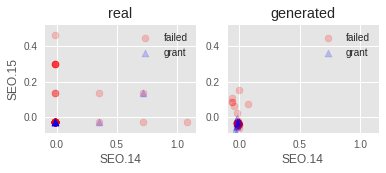

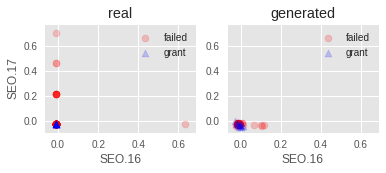

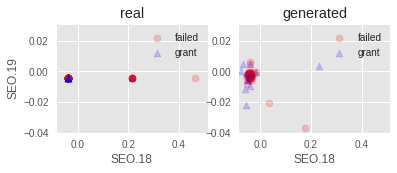

In [44]:
colors = ['red','blue']
markers = ['o','^']
labels = ['failed','grant']

class_label = 'Grant.Status'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()


In [45]:
SimpleMetrics(y_pred,y_true)

Confusion Matrix


,Pred 0,Pred 1
True 0,100,0
True 1,1,99


Accuracy : 0.995


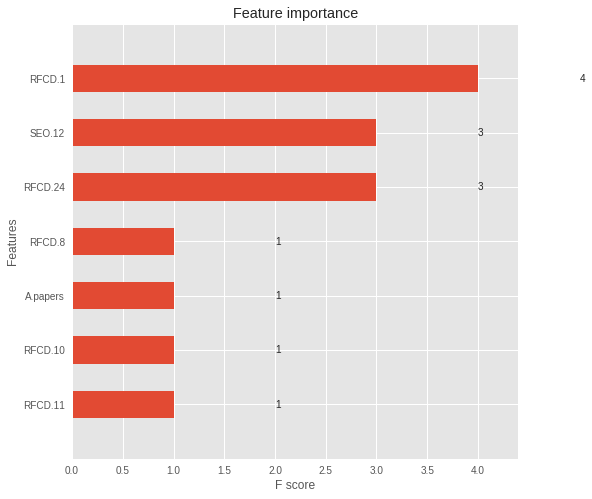

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, height=0.5, ax=ax);

In [0]:
train = grant_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

train = pd.get_dummies(train, columns=['Grant.Status'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)


In [0]:
rand_dim = 32
base_n_count = 128
model_names = ['GAN','CGAN','WGAN','WCGAN']
with_classes = [False, True, False, True]
type0s = [None, None, 'Wasserstein', 'Wasserstein']

models = {}

for model_name, with_class, type0 in zip(model_names, with_classes, type0s ):

    if with_class:
        generator_model, discriminator_model, combined_model = \
            define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type=type0)
    else:
         generator_model, discriminator_model, combined_model = \
            define_models_GAN(rand_dim, data_dim, base_n_count, type=type0)   
    
    models[model_name] = [ model_name, with_class, type0, generator_model ]


In [0]:
seed = 17
test_size = 492 # number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(test_size, rand_dim))
x = get_data_batch(train, test_size, seed=seed)
real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
labels = x[:,-label_dim:]

# colors = ['C1','C9']
# colors = ['xkcd:plum', 'xkcd:navy']
colors = ['red','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache lr mix base 128 act mix 171026/'

0


KeyError: ignored

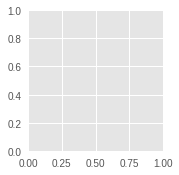

In [50]:
model_steps = [ 0, 1000, 2000, 3000, 4000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip( real_samples.groupby('Grant.Status_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, type0, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Grant.Status_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)
